In [1]:
import os

os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu0,nvcc.fastmath=True,optimizer=fast_compile'

In [2]:
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy import ndimage

%matplotlib inline

from keras.layers import Layer, Dense, Activation, Flatten, Lambda, BatchNormalization, Reshape, Dropout, ELU
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.layers import LSTM, GRU, TimeDistributed
from keras.engine import merge, Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import *
from keras.utils import np_utils
import keras.backend as K
import time
import random
import pickle
import json
import csv
from tqdm import tqdm
from natsort import natsorted

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from helper import to_rle
from segmentation import *
from imagegen import CustomImageDataGenerator

# for preventing python max recursion limit error
import sys
sys.setrecursionlimit(50000)

DATADIR = os.path.expanduser('~/data/kaggle/ultrasound-nerve-segmentation')
PROCDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/processed')
MODELDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/models')
SUBMITDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/submissions')

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5004)


In [3]:
WEIGHTS_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-11-segment-weights.hdf5')
HISTORY_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-11-segment-training-history.json')

In [4]:
with open(os.path.join(PROCDIR, 'train_files_map.pkl'), 'rb') as f:
    train_files_map = pickle.load(f)
with open(os.path.join(PROCDIR, 'test_files_map.pkl'), 'rb') as f:
    test_files_map = pickle.load(f)

In [5]:
with open(os.path.join(PROCDIR, 'data_train_val_11.pkl'), 'rb') as f:
    (data_images_train, data_masks_train, data_presence_train, 
     data_images_val, data_masks_val, data_presence_val) = pickle.load(f)

print('image shapes:', data_images_train.shape, data_images_val.shape)
print('mask shapes:', data_masks_train.shape, data_masks_val.shape)
print('presence label shapes:', data_presence_train.shape, data_presence_val.shape)

image shapes: (5156, 1, 256, 256) (479, 1, 256, 256)
mask shapes: (5156, 1, 256, 256) (479, 1, 256, 256)
presence label shapes: (5156,) (479,)


## segmentation model

In [6]:
def rotate90(X, direction='clockwise'):
    if direction == 'clockwise':
        return X.transpose((0, 2, 1))[:, :, ::-1]
    elif direction == 'counterclockwise':
        return X.transpose((0, 2, 1))[:, ::-1, :]
    else:
        raise

In [7]:
start_time = time.time()

orig_img_rows, orig_img_cols = 420, 580
img_rows, img_cols = 256, 256
img_channels = 1

images = Input(shape=(img_channels, img_rows, img_cols))

x = Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(images)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th')(x)

x = Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th')(x)

x = Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th')(x)

x = Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th')(x)

x = Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th')(x)

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Reshape((64, 8, 8))(x)

x = UpSampling2D(size=(2, 2), dim_ordering='th')(x)
x = Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)

x = UpSampling2D(size=(2, 2), dim_ordering='th')(x)
x = Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)

x = UpSampling2D(size=(2, 2), dim_ordering='th')(x)
x = Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)

x = UpSampling2D(size=(2, 2), dim_ordering='th')(x)
x = Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)

x = UpSampling2D(size=(2, 2), dim_ordering='th')(x)
x = Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)
x = Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th')(x)
x = BatchNormalization(axis=1)(x)
x = ELU()(x)

x = Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th')(x)
x = Reshape((img_rows, img_cols))(x)
x = Dropout(0.5)(x)

rnn_we = GRU(img_cols, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True)(x)
rnn_ew = GRU(img_cols, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True)(x)
rnn_we_ew = merge([rnn_we, rnn_ew], mode='concat', concat_axis=-1)
rnn_we_ew = TimeDistributed(Dense(img_cols, init='uniform', activation='sigmoid'))(rnn_we_ew)

x_rotate = Lambda(rotate90, arguments={'direction': 'counterclockwise'})(x)
rnn_ns = GRU(img_rows, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True)(x_rotate)
rnn_sn = GRU(img_rows, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True)(x_rotate)
rnn_ns_sn = merge([rnn_ns, rnn_sn], mode='concat', concat_axis=-1)
rnn_ns_sn = TimeDistributed(Dense(img_rows, init='uniform', activation='sigmoid'))(rnn_ns_sn)
rnn_ns_sn = Lambda(rotate90, arguments={'direction': 'clockwise'})(rnn_ns_sn)

segmentation = merge([rnn_we_ew, rnn_ns_sn], mode='mul')

model_segment = Model(input=images, output=segmentation)

print('model init time: {}'.format(time.time() - start_time))

start_time = time.time()

model_segment.compile(optimizer='adam', loss=binaryCE, metrics=[dice_coeff])

print('model compile time: {}'.format(time.time() - start_time))

model init time: 5.1810972690582275
model compile time: 0.00992274284362793


## segmentation model train

In [8]:
class CustomImageDataGenerator(ImageDataGenerator):
    def random_transform(self, x, y):
        # x is a single image, so it doesn't have image number at index 0
        img_row_index = self.row_index - 1
        img_col_index = self.col_index - 1
        img_channel_index = self.channel_index - 1

        # use composition of homographies to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_index]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_index]
        else:
            ty = 0

        translation_matrix = np.array([[1, 0, tx],
                                       [0, 1, ty],
                                       [0, 0, 1]])
        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])

        transform_matrix = np.dot(np.dot(np.dot(rotation_matrix, translation_matrix), shear_matrix), zoom_matrix)

        h, w = x.shape[img_row_index], x.shape[img_col_index]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        x = apply_transform(x, transform_matrix, img_channel_index,
                            fill_mode=self.fill_mode, cval=self.cval)
        y = apply_transform(y, transform_matrix, img_channel_index,
                            fill_mode=self.fill_mode, cval=self.cval)
        if self.channel_shift_range != 0:
            x = random_channel_shift(x, self.channel_shift_range, img_channel_index)
            y = random_channel_shift(y, self.channel_shift_range, img_channel_index)

        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_index)
                y = flip_axis(y, img_col_index)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_index)
                y = flip_axis(y, img_row_index)
                
        return x, y
    
    def next(self):
        # for python 2.x.
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see # http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            index_array, current_index, current_batch_size = next(self.flow_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        bX = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
        bY = np.zeros(tuple([current_batch_size] + list(self.y.shape)[2:]))
        for i, j in enumerate(index_array):
            x = self.X[j]
            y = self.y[j]
            x, y = self.random_transform(x.astype('float32'), y.astype('float32'))
            x = self.standardize(x)
            bX[i] = x
            bY[i] = y[0,:,:].astype('bool')
        return bX, bY

In [23]:
datagen = CustomImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    dim_ordering='th')
    
datagen.fit(data_images_train)

In [24]:
testx, testy = next(datagen.flow(data_images_train[5:6], data_masks_train[5:6], batch_size=1))

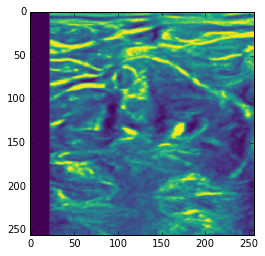

In [25]:
plt.imshow(testx[0,0,:,:], cmap=plt.cm.viridis)

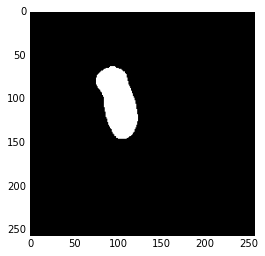

In [26]:
plt.imshow(data_masks_train[5,0,:,:], cmap=plt.cm.bone)

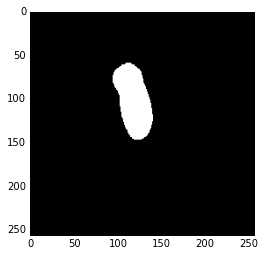

In [27]:
plt.imshow(testy[0,:,:], cmap=plt.cm.bone)

In [9]:
batch_size = 32
nb_epoch = 3

datagen = CustomImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    dim_ordering='th')
    
datagen.fit(data_images_train)

model_segment.fit_generator(datagen.flow(data_images_train, data_masks_train, batch_size=batch_size),
                            samples_per_epoch=data_images_train.shape[0],
                            nb_epoch=nb_epoch, verbose=1,
                            validation_data=(data_images_val, data_masks_val[:,0,:,:]),
                            callbacks=[])

Epoch 1/3
5156/5156 [==============================] - 490s - loss: 0.0571 - dice_coeff: 4.3755e-05 - val_loss: 0.0390 - val_dice_coeff: 6.0226e-05
Epoch 2/3
5156/5156 [==============================] - 483s - loss: 0.0488 - dice_coeff: 0.0016 - val_loss: 0.0397 - val_dice_coeff: 0.0528
Epoch 3/3
5156/5156 [==============================] - 481s - loss: 0.0436 - dice_coeff: 0.0590 - val_loss: 0.0332 - val_dice_coeff: 0.2402


## test

In [6]:
with tf.device('/gpu:0'):
    model_presence.load_weights(WEIGHTS_PRESENCE_FILEPATH)

In [8]:
with tf.device('/gpu:1'):
    model_segment.load_weights(WEIGHTS_SEGMENT_FILEPATH)

presence prediction:  [ 0.49604669] [False]


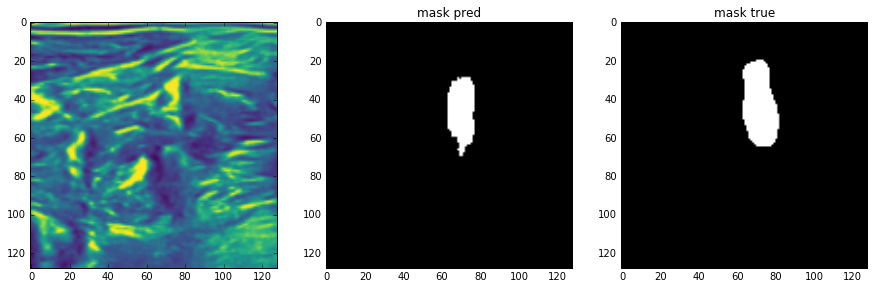

In [19]:
rand_i = random.randint(0, data_images_val.shape[0] - 1)

image = data_images_val[rand_i:rand_i+1]
mask = data_masks_val[rand_i, :, :]

presence = model_presence.predict(image, verbose=0)[0]
print('presence prediction: ', presence, presence > 0.5)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image[0,:,:,0], cmap=plt.cm.viridis)
plt.subplot(1,3,2)
plt.title('mask pred')
plt.imshow(model_segment.predict(image, verbose=0)[0, :, :] > 0.5, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.title('mask true')
plt.imshow(mask, cmap=plt.cm.bone)

In [20]:
# presence classification metrics
presence = model_presence.predict(data_images_val, verbose=0)
print('confusion matrix:\n', confusion_matrix(data_presence_val, presence > 0.5), '\n')
print('ROC AUC: ', roc_auc_score(data_presence_val, presence), '\n')
print(classification_report(data_presence_val, presence > 0.5, target_names=['BP not present', 'BP present']), '\n')

confusion matrix:
 [[168  60]
 [ 41 211]] 

ROC AUC:  0.866158451685 

                precision    recall  f1-score   support

BP not present       0.80      0.74      0.77       228
    BP present       0.78      0.84      0.81       252

   avg / total       0.79      0.79      0.79       480
 



In [21]:
preds_segment = model_segment.predict(data_images_val, verbose=0)
np.mean(2 * np.sum(data_masks_val * preds_segment>0.5) / (np.sum(data_masks_val) + np.sum(preds_segment>0.5) + 1e-6), axis=None)

0.66327890342835172

In [36]:
preds_presence = model_presence.predict(data_images_val, verbose=0)
preds_segment = model_segment.predict(data_images_val, verbose=0)
preds_mod = []
for i in range(preds_segment.shape[0]):
    if preds_presence[i] < 0.25:
        preds_mod.append(preds_segment[i,:,:]>0.9)
    elif preds_presence[i] > 0.75:
        preds_mod.append(preds_segment[i,:,:]>0.4)
    else:
        preds_mod.append(preds_segment[i,:,:]>0.5)
np.mean(2 * np.sum(data_masks_val * preds_mod) / (np.sum(data_masks_val) + np.sum(preds_mod) + 1e-6), axis=None)

0.68225815981217131

In [9]:
with open(os.path.join(SUBMITDIR, 'model-09.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['img', 'pixels'])

    for key in tqdm(natsorted(list(test_files_map.keys()))):
        file_info = test_files_map[key]
        img, folder, img_file = file_info['img'], file_info['folder'], file_info['img_file']
        img_filepath = os.path.join(folder, img_file)
        image = io.imread(img_filepath) / 255.0
        image_resized = np.expand_dims(imresize(image, size=(img_rows, img_cols), interp='bilinear'), axis=3)
        presence = model_presence.predict(np.array([image_resized], dtype=np.float32), verbose=0)[0]
        mask_pred = model_segment.predict(np.array([image_resized], dtype=np.float32), verbose=0)[0, :, :]
        mask_pred_orig_size = imresize(mask_pred > 0.5, size=(orig_img_rows, orig_img_cols), interp='bilinear').astype(np.bool)
        rle = to_rle(mask_pred_orig_size)
        writer.writerow([img, rle])

 11%|█         | 596/5508 [01:24<11:08,  7.34it/s]/home/leon/install/miniconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5508/5508 [12:56<00:00,  6.87it/s]
